In [94]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
import galsim
from pyHalo.preset_models import CDM
from copy import deepcopy
from lenstronomy.Util.correlation import power_spectrum_1d

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):  # ../../
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs, psf

In [95]:
ps_dir = os.path.join(array_dir, 'power_spectra')

In [131]:
pprint(sorted(glob(os.path.join(ps_dir, 'im_subs_*_00000000.npy')))[:4])

['/data/scratch/btwedig/mejiro/output/arrays/power_spectra/im_subs_cut_6_00000000.npy',
 '/data/scratch/btwedig/mejiro/output/arrays/power_spectra/im_subs_cut_7_00000000.npy',
 '/data/scratch/btwedig/mejiro/output/arrays/power_spectra/im_subs_cut_8_00000000.npy',
 '/data/scratch/btwedig/mejiro/output/arrays/power_spectra/im_subs_no_subhalos_00000000.npy']


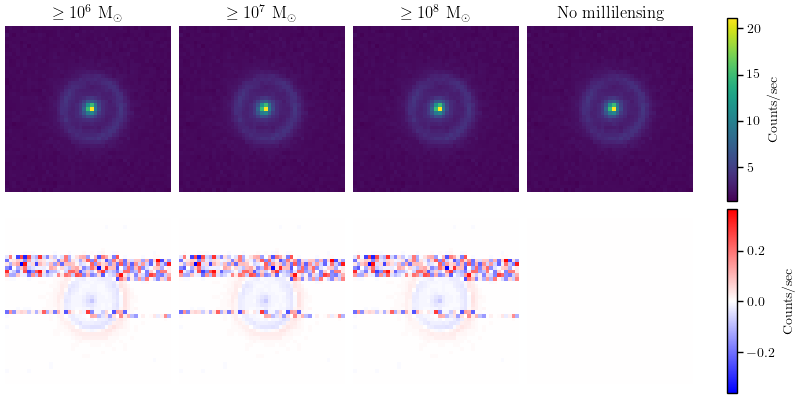

In [210]:
id = np.random.randint(0, 20)
uid = str(id).zfill(8)

images = [np.load(i) for i in sorted(glob(os.path.join(ps_dir, f'im_subs_*_{uid}.npy')))]
# kappa_images = [np.load(i) for i in glob(os.path.join(ps_dir, 'kappa_im_*.npy'))]

r = np.load(os.path.join(ps_dir, 'r.npy'))
# kappa_r = np.load(os.path.join(ps_dir, 'kappa_r.npy'))

f, ax = plt.subplots(2, 4, figsize=(8, 4), constrained_layout=True)

res_array = [images[3] - images[i] for i in range(4)]
v = plot_util.get_v(res_array)

for i in range(4):
    axis = ax[0][i].imshow(images[i])
    ax[0][i].set_axis_off()

cbar = f.colorbar(axis, ax=ax[0])
cbar.set_label('Counts/sec', rotation=90)

for i in range(4):
    axis = ax[1][i].imshow(images[3] - images[i], cmap='bwr', vmin=-v, vmax=v)
    ax[1][i].set_axis_off()

cbar = f.colorbar(axis, ax=ax[1])
cbar.set_label('Counts/sec', rotation=90)

ax[0][0].set_title('$\geq 10^6$ M$_\odot$')
ax[0][1].set_title('$\geq 10^7$ M$_\odot$')
ax[0][2].set_title('$\geq 10^8$ M$_\odot$')
ax[0][3].set_title('No millilensing')

plt.savefig(os.path.join(repo_dir, 'figures', 'artifacts.png'))
plt.show()

In [98]:
limit = 500

power_list_no_subhalos = [np.load(i) for i in sorted(glob(os.path.join(ps_dir, f'ps_subs_no_subhalos_*.npy')))][:limit]
power_list_cut_6 = [np.load(i) for i in sorted(glob(os.path.join(ps_dir, f'ps_subs_cut_6_*.npy')))][:limit]
power_list_cut_7 = [np.load(i) for i in sorted(glob(os.path.join(ps_dir, f'ps_subs_cut_7_*.npy')))][:limit]
power_list_cut_8 = [np.load(i) for i in sorted(glob(os.path.join(ps_dir, f'ps_subs_cut_8_*.npy')))][:limit]

stack_no_subhalos = np.vstack(power_list_no_subhalos)
stack_list_cut_6 = np.vstack(power_list_cut_6)
stack_list_cut_7 = np.vstack(power_list_cut_7)
stack_list_cut_8 = np.vstack(power_list_cut_8)

In [99]:
# power_list_no_subhalos_kappa = [np.load(i) for i in glob(os.path.join(ps_dir, f'kappa_ps_*_no_subhalos.npy'))]
# power_list_cut_6_kappa = [np.load(i) for i in glob(os.path.join(ps_dir, f'kappa_ps_*_cut_6.npy'))]
# power_list_cut_7_kappa = [np.load(i) for i in glob(os.path.join(ps_dir, f'kappa_ps_*_cut_7.npy'))]
# power_list_cut_8_kappa = [np.load(i) for i in glob(os.path.join(ps_dir, f'kappa_ps_*_cut_8.npy'))]

# stack_no_subhalos_kappa = np.vstack(power_list_no_subhalos_kappa)
# stack_list_cut_6_kappa = np.vstack(power_list_cut_6_kappa)
# stack_list_cut_7_kappa = np.vstack(power_list_cut_7_kappa)
# stack_list_cut_8_kappa = np.vstack(power_list_cut_8_kappa)

In [100]:
# plt.plot(r, np.mean(stack_list_cut_8, axis=0), label='$\geq 10^8$ M$_\odot$')
# plt.plot(r, np.mean(stack_list_cut_7, axis=0), label='$\geq 10^7$ M$_\odot$')
# plt.plot(r, np.mean(stack_list_cut_6, axis=0), label='$\geq 10^6$ M$_\odot$')
# plt.plot(r, np.mean(stack_no_subhalos, axis=0), label='No subhalos')
# plt.xscale('log')
# plt.legend()
# plt.show()

In [101]:
res_8 = np.mean(stack_list_cut_8, axis=0) - np.mean(stack_no_subhalos, axis=0)
res_7 = np.mean(stack_list_cut_7, axis=0) - np.mean(stack_no_subhalos, axis=0)
res_6 = np.mean(stack_list_cut_6, axis=0) - np.mean(stack_no_subhalos, axis=0)

# TODO fix
percentile_8 = np.percentile(stack_list_cut_8 - stack_no_subhalos, [25, 75], axis=0)
percentile_7 = np.percentile(stack_list_cut_7 - stack_no_subhalos, [25, 75], axis=0)
percentile_6 = np.percentile(stack_list_cut_6 - stack_no_subhalos, [25, 75], axis=0)

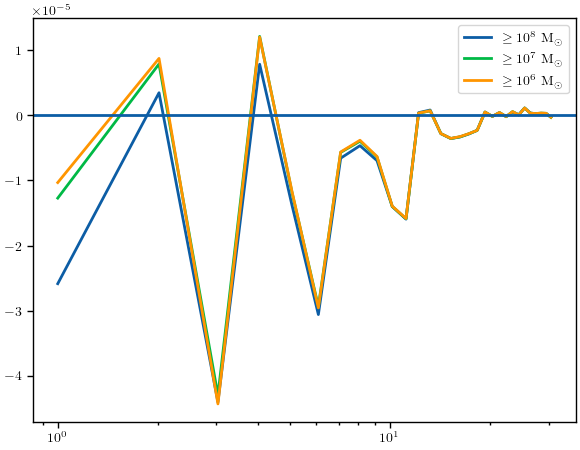

In [118]:
plt.plot(r, res_8, label='$\geq 10^8$ M$_\odot$')
plt.plot(r, res_7, label='$\geq 10^7$ M$_\odot$')
plt.plot(r, res_6, label='$\geq 10^6$ M$_\odot$')
plt.axhline(0)

# for i in range(2):
#     plt.plot(r, percentile_8[i], color='b', linestyle=':')
#     plt.plot(r, percentile_7[i], color='g', linestyle=':')
#     plt.plot(r, percentile_6[i], color='orange', linestyle=':')

plt.xscale('log')
plt.legend()
plt.show()

In [103]:
# res_8_kappa = np.mean(stack_list_cut_8_kappa, axis=0) - np.mean(stack_no_subhalos_kappa, axis=0)
# res_7_kappa = np.mean(stack_list_cut_7_kappa, axis=0) - np.mean(stack_no_subhalos_kappa, axis=0)
# res_6_kappa = np.mean(stack_list_cut_6_kappa, axis=0) - np.mean(stack_no_subhalos_kappa, axis=0)

In [104]:
# plt.plot(r, res_8_kappa, label='$\geq 10^8$ M$_\odot$')
# plt.plot(r, res_7_kappa, label='$\geq 10^7$ M$_\odot$')
# plt.plot(r, res_6_kappa, label='$\geq 10^6$ M$_\odot$')
# plt.xscale('log')
# plt.legend()
# plt.show()

In [105]:
power_list_nominal = [np.load(i) for i in sorted(glob(os.path.join(ps_dir, f'ps_det_4_*.npy')))][:limit]
power_list_1 = [np.load(i) for i in sorted(glob(os.path.join(ps_dir, f'ps_det_1_*.npy')))][:limit]
power_list_9 = [np.load(i) for i in sorted(glob(os.path.join(ps_dir, f'ps_det_9_*.npy')))][:limit]
power_list_17 = [np.load(i) for i in sorted(glob(os.path.join(ps_dir, f'ps_det_17_*.npy')))][:limit]

stack_nominal = np.vstack(power_list_nominal)
stack_list_1 = np.vstack(power_list_1)
stack_list_9 = np.vstack(power_list_9)
stack_list_17 = np.vstack(power_list_17)

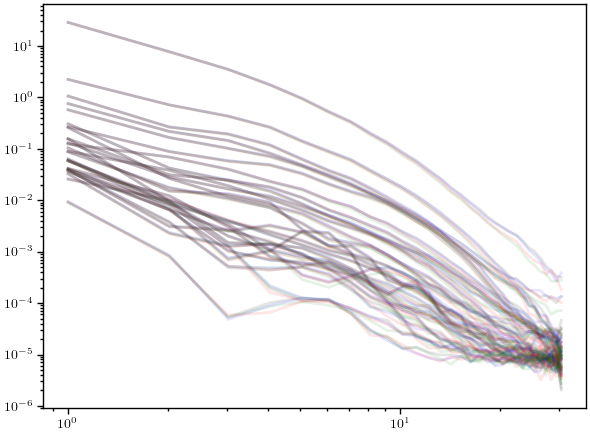

In [106]:
for ps in power_list_nominal:
    plt.loglog(r, ps, color='black', alpha=0.1)
for ps in power_list_1:
    plt.loglog(r, ps, color='blue', alpha=0.1)
for ps in power_list_9:
    plt.loglog(r, ps, color='red', alpha=0.1)
for ps in power_list_17:
    plt.loglog(r, ps, color='green', alpha=0.1)
plt.show()

In [107]:
dif_1 = np.mean(stack_list_1, axis=0) - np.mean(stack_nominal, axis=0)
dif_9 = np.mean(stack_list_9, axis=0) - np.mean(stack_nominal, axis=0)
dif_17 = np.mean(stack_list_17, axis=0) - np.mean(stack_nominal, axis=0)

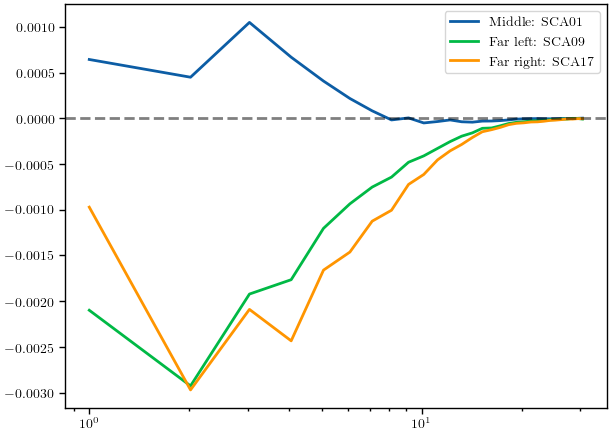

In [108]:
plt.plot(r, dif_1, label='Middle: SCA01')
plt.plot(r, dif_9, label='Far left: SCA09')
plt.plot(r, dif_17, label='Far right: SCA17')
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.xscale('log')
plt.legend()
plt.show()

In [109]:
np.save(os.path.join(ps_dir, 'res_6'), res_6)
np.save(os.path.join(ps_dir, 'res_7'), res_7)
np.save(os.path.join(ps_dir, 'res_8'), res_8)
np.save(os.path.join(ps_dir, 'r.npy'), r)

In [110]:
res_6 = np.load(os.path.join(ps_dir, 'res_6.npy'))
res_7 = np.load(os.path.join(ps_dir, 'res_7.npy'))
res_8 = np.load(os.path.join(ps_dir, 'res_8.npy'))

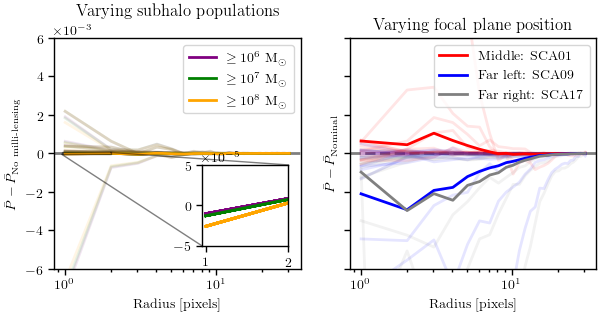

In [125]:
f, ax = plt.subplots(1, 2, figsize=(7, 3), sharey=True)

limit = 15

from matplotlib.lines import Line2D
custom_lines_1 = [Line2D([0], [0], color='purple'),
                Line2D([0], [0], color='green'),
                Line2D([0], [0], color='orange')]

# ax.plot(r, flat_ps, label='flat')
# ax.plot(r, ps_no_subhalos, label='No subhalos')
ax[0].axhline(0, color='black', linestyle='--', alpha=0.5)

# for each in percentile_8:
#     ax[0].plot(r, each, color='purple', alpha=0.5, linestyle=':')

for i in range(limit):  #  + np.random.randint(0, 90)
    ax[0].plot(r, [cut - none for cut, none in zip(power_list_cut_6[i], power_list_no_subhalos[i])], label='$\geq 10^6$ M$_\odot$', alpha=0.1, color='purple')
    ax[0].plot(r, [cut - none for cut, none in zip(power_list_cut_7[i], power_list_no_subhalos[i])], label='$\geq 10^7$ M$_\odot$', alpha=0.1, color='green')
    ax[0].plot(r, [cut - none for cut, none in zip(power_list_cut_8[i], power_list_no_subhalos[i])], label='$\geq 10^8$ M$_\odot$', alpha=0.1, color='orange')

ax[0].plot(r, res_6, color='purple')
ax[0].plot(r, res_7, color='green')
ax[0].plot(r, res_8, color='orange')

ax[0].set_xscale('log')
ax[0].set_xlabel('Radius [pixels]')
ax[0].set_ylabel(r'$\bar{P} - \bar{P}_{\textrm{No milli-lensing}}$')
# ax[0].legend()
ax[0].legend(custom_lines_1, ['$\geq 10^6$ M$_\odot$', '$\geq 10^7$ M$_\odot$', '$\geq 10^8$ M$_\odot$'])
ax[0].set_title('Varying subhalo populations')

x1, x2, y1, y2 = 0.95, 2, -5e-5, 5e-5
zoom_axes = ax[0].inset_axes(bounds=[0.6,0.1,0.35,0.35], xlim=(x1, x2), ylim=(y1, y2))  # xticklabels=[1, 2], yticklabels=[-1e-3, 0, 1e-3]
for i in range(limit):
    zoom_axes.plot(r, res_6, color='purple')
    zoom_axes.plot(r, res_7, color='green')
    zoom_axes.plot(r, res_8, color='orange')
    # zoom_axes.plot(r, [cut - none for cut, none in zip(power_list_cut_6[i], power_list_no_subhalos[i])], label='$\geq 10^6$ M$_\odot$', alpha=0.1, color='blue')
    # zoom_axes.plot(r, [cut - none for cut, none in zip(power_list_cut_7[i], power_list_no_subhalos[i])], label='$\geq 10^7$ M$_\odot$', alpha=0.1, color='green')
    # zoom_axes.plot(r, [cut - none for cut, none in zip(power_list_cut_8[i], power_list_no_subhalos[i])], label='$\geq 10^8$ M$_\odot$', alpha=0.1, color='orange')
zoom_axes.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False, labelbottom=True, labeltop=False, labelleft=True, labelright=False)
ax[0].indicate_inset_zoom(zoom_axes, edgecolor="black")

custom_lines_2 = [Line2D([0], [0], color='red'),
                Line2D([0], [0], color='blue'),
                Line2D([0], [0], color='grey')]

ax[1].axhline(0, color='black', linestyle='--', alpha=0.5)
for i in range(limit):
    ax[1].plot(r, [cut - none for cut, none in zip(power_list_1[i], power_list_nominal[i])], alpha=0.1, color='red')
    ax[1].plot(r, [cut - none for cut, none in zip(power_list_9[i], power_list_nominal[i])], alpha=0.1, color='blue')
    ax[1].plot(r, [cut - none for cut, none in zip(power_list_17[i], power_list_nominal[i])], alpha=0.1, color='grey')
ax[1].plot(r, dif_1, color='red')
ax[1].plot(r, dif_9, color='blue')
ax[1].plot(r, dif_17, color='grey')
ax[1].set_xscale('log')
ax[1].set_xlabel('Radius [pixels]')
ax[1].set_ylabel(r'$\bar{P} - \bar{P}_{\textrm{Nominal}}$')
# ax[1].legend()
ax[1].legend(custom_lines_2, ['Middle: SCA01', 'Far left: SCA09', 'Far right: SCA17'])
ax[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax[1].set_title('Varying focal plane position')

# ax[2].axhline(0, color='black', linestyle='--', alpha=0.5)
# ax[2].plot(kappa_r, res_8_kappa, label='$\geq 10^6$ M$_\odot$')
# ax[2].plot(kappa_r, res_7_kappa, label='$\geq 10^7$ M$_\odot$')
# ax[2].plot(kappa_r, res_6_kappa, label='$\geq 10^8$ M$_\odot$')
# ax[2].set_xscale('log')
# ax[2].set_xlabel('Radius [pixels]')
# ax[2].set_ylabel(r'P - P$_{\textrm{No subhalos}}$')
# ax[2].legend()
# ax[2].set_title('Convergence maps')

ax[0].set_ylim([-6e-3, 6e-3])

plt.savefig(os.path.join(figure_dir, 'power_spectra.png'), dpi=1200)
plt.show()